<a href="https://colab.research.google.com/github/trisha311/Final-Capstone-AI-in-Dermatology/blob/master/Trisha_Thompson_Final_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

I have used computer vision and deep learning techniques to build a model for identifying Eczema and Psoriasis from a racially diverse dataset. 
Eczema and Psoriasis are both extremely prevalent with over 31 million Americans having Eczema<sup>1</sup> and over 7.5 million Americans, living with Psoriasis<sup>2</sup>. While both conditions cause inflammation and itching and can often be visually very similar; their causes and treatments are distinctly different. Psoriasis is the result of an autoimmune dysfunction, causing skin cells to multiply too fast; while the causes of Eczema are more varied, ranging from genetics to conditional factors.  With their causes being so different, effective treatment methods for these two common conditions are also very different - making correct diagnosis between these two conditions especially important.
 
This capstone is part of a more comprehensive project aimed at creating an open source dermatological diagnostic web application to be used in rural areas of Nigeria, where there are only approximately 100 dermatologists serving a population of over 190 million<sup>3</sup>. The primary project also aims to provide a validated image dataset to be made public for future machine learning projects and research. A link to the full AI in Dermatology project can be found below.

https://www.aidermatology.org/



#Data Set

I scraped a total of 714 images from a Google image search for 'Eczema' and 749 images from a Google image search for 'Psoriasis'. The Jupyter Notebook for scraping these images can be found in the link below.

https://github.com/trisha311/Final-Capstone-AI-in-Dermatology/blob/master/Final_Capstone_DataSet.ipynb  

After removing all images that were not of photos of Psoriasis or Eczema (ie images of lotions or ointments for treatment, "after" images from before and after treatment photos, and infographics or other drawings or non-photographic representations of Eczema or Psoriasis), I was left with a data set with 394 images of Eczema and 408 images of Psoriasis, which I uploaded to Google Drive for use in Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
import pandas as pd
from collections import Counter
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#read in image dataset from drive and store in list
CATEGORIES = ['eczema', 'psoriasis']
DATADIR = '/content/drive/My Drive/pictures'

image_data = []

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  class_num = CATEGORIES.index(category)
  for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path, img))
      image_data.append([img_array, class_num])

In [ ]:
#confirm all 802 images have been read into the notebook
len(image_data)

802

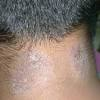

Image Size and Number of Color Channels: (100, 100, 3)
Skin Condition: 0


In [ ]:
#display sample images and shape from dataset
cv2_imshow(image_data[0][0])
print('Image Size and Number of Color Channels: {}'.format(image_data[0][0].shape))
print('Skin Condition: {}'.format(image_data[0][1]))

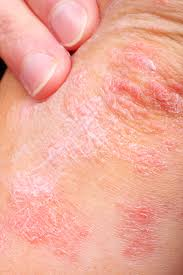

Image Size and Number of Color Channels: (275, 183, 3)
Skin Condition: 1


In [ ]:
cv2_imshow(image_data[500][0])
print('Image Size and Number of Color Channels: {}'.format(image_data[500][0].shape))
print('Skin Condition: {}'.format(image_data[500][1]))

##Resize Images
Since the images sizes in the dataset varied, I resized all images to the  average image height and width in preparation for training the neural network.

In [ ]:
from statistics import mean
from statistics import mode

In [ ]:
#determine average image size
image_height = []
image_width = []
for image in image_data:
  image_height.append(image[0].shape[0])
  image_width.append(image[0].shape[1])

print('Average Image Height: {}'.format(round(mean(image_height),0)))
print('Average Image Width: {}'.format(round(mean(image_width),0)))

Average Image Height: 184.0
Average Image Width: 250.0


In [ ]:
#resize all images to the average image height and width.
IMG_HT = 184
IMG_WD = 250

img_data = []

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  class_num = CATEGORIES.index(category)
  for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path, img))
      new_array = cv2.resize(img_array,(IMG_WD, IMG_HT))
      img_data.append([new_array, class_num])

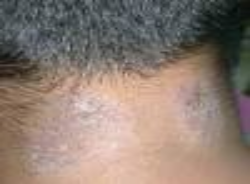

Image Size and Number of Color Channels: (184, 250, 3)
Skin Condition: 0


In [ ]:
#view resized images:
cv2_imshow(img_data[0][0])
print('Image Size and Number of Color Channels: {}'.format(img_data[0][0].shape))
print('Skin Condition: {}'.format(img_data[0][1]))

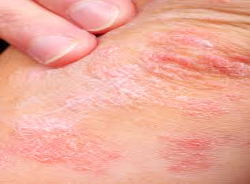

Image Size and Number of Color Channels: (184, 250, 3)
Skin Condition: 1


In [ ]:
cv2_imshow(img_data[500][0])
print('Image Size and Number of Color Channels: {}'.format(img_data[500][0].shape))
print('Skin Condition: {}'.format(img_data[500][1]))

##Assess Diversity of Skin Pigmentation in Image Dataset
As this capstone is part of a larger project aimed at addressing the inaccessibility of dermatological services in Africa, it is essential that the dataset include images of skin with diverse levels of pigmentation.  In order to classify the scraped images into levels of skin pigmentation, I used the same RBG ranges and classes as those used by M.A.H. Akhand in the paper *Improvement of Haar Feature Based Face Detection in OpenCV Incorporating Human Skin Color Characteristic*.  

Below is an image of the used RGB color classes; where the class of 1 represents the darkest or most pigmented tone, and 18 represents the lightest or least pigmented skin tone.

![alt text](https://drive.google.com/uc?id=1eU52FRcmAVecKhVWlOrRGAuEXWPwF8VS)



In [ ]:
#import dataframe with skin color classifications 
skin_color_classes_df = pd.read_csv('/content/drive/My Drive/AI in Dermatology Project/SkinColorClasses.csv')

In [ ]:
skin_color_classes_df

Low  High  Category
0     0    30         1
1    31    40         2
2    41    50         3
3    51    60         4
4    61    70         5
5    71    80         6
6    81    90         7
7    91   100         8
8   101   110         9
9   111   120        10
10  121   130        11
11  131   140        12
12  141   150        13
13  151   160        14
14  161   170        15
15  171   180        16
16  181   190        17
17  191   255        18

In [ ]:
#create dictionary of skin color classes from dataframe
skin_color_classes_dict = {}
for i in range(0, skin_color_classes_df.shape[0]):
  skin_color_classes_dict[i+1] = range(skin_color_classes_df.loc[i]['Low'], skin_color_classes_df.loc[i]['High']+1)
skin_color_classes_dict

{1: range(0, 31),
 2: range(31, 41),
 3: range(41, 51),
 4: range(51, 61),
 5: range(61, 71),
 6: range(71, 81),
 7: range(81, 91),
 8: range(91, 101),
 9: range(101, 111),
 10: range(111, 121),
 11: range(121, 131),
 12: range(131, 141),
 13: range(141, 151),
 14: range(151, 161),
 15: range(161, 171),
 16: range(171, 181),
 17: range(181, 191),
 18: range(191, 256)}


As the primary subject of all images in the dataset were areas of skin with either Psoriasis or Eczema, I used Kmeans clusters to identify the dominant color in each image and then assigned a skin pigmentation class according to the RGB values of the dominant color and the table above.


In [ ]:
#find dominant color in image

#the following was adaped from code in the Medium article, "Finding Dominant Colour on an Image" by Ayşe Bilge Gündüz, published on September 18, 2017 from the link below:
#https://code.likeagirl.io/finding-dominant-colour-on-an-image-b4e075f98097

def get_dominant_color(image, k=4, image_processing_size = None):
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)
    label_counts = Counter(labels)
    dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]
    return list(dominant_color)

In [ ]:
#classify dominant color
def classify_color(dominant_color):
  x = dominant_color[0]
  x = round(x,0)
  for i in range(1,19):
    if x in skin_color_classes_dict[i]:
      return i

In [ ]:
original_skin_pigment_classes = []

for i in range(0,len(img_data)):
  dominant_color = get_dominant_color(img_data[i][0])
  original_skin_pigment_classes.append(classify_color(dominant_color))

original_skin_pigment_classes[0:10]

[8, 10, 11, 18, 11, 13, 13, 12, 12, 9]

In [ ]:
#place image arrays into a list
img_arrays = []
for i in range (0, len(img_data)):
  img_arrays.append(img_data[i][0])

In [ ]:
#place skin conditions into a list
skin_conditions = []
for i in range (0, len(img_data)):
  skin_conditions.append(img_data[i][1])

In [ ]:
#create dataframe with numpy arrays, skin condition, and skin pigment class for all images:
data = {'image_array': img_arrays,
        'skin_condition_class': skin_conditions,
        'skin_pigmentation_class': original_skin_pigment_classes,}

df = pd.DataFrame(data)

In [ ]:
df.head()

image_array  ...  skin_pigmentation_class
0  [[[64, 61, 53], [65, 62, 54], [70, 67, 59], [7...  ...                        8
1  [[[243, 234, 231], [244, 235, 232], [247, 238,...  ...                       10
2  [[[135, 146, 144], [135, 146, 144], [134, 145,...  ...                       11
3  [[[236, 237, 228], [235, 237, 228], [234, 236,...  ...                       18
4  [[[115, 141, 178], [114, 141, 177], [113, 139,...  ...                       11

[5 rows x 3 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   image_array           802 non-null    object
 1   skin_condition_class  802 non-null    int64 
 2   skin_pigment_class    802 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 18.9+ KB


In [ ]:
df['skin_pigment_class'].value_counts(ascending=False)

18    144
11     59
14     59
12     54
10     53
15     53
13     53
1      52
9      49
8      43
17     35
7      34
16     31
6      21
5      18
2      17
4      14
3      13
Name: skin_pigment_class, dtype: int64

In [ ]:
bin_list = list(range(1,19))
bin_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

<function matplotlib.pyplot.show>

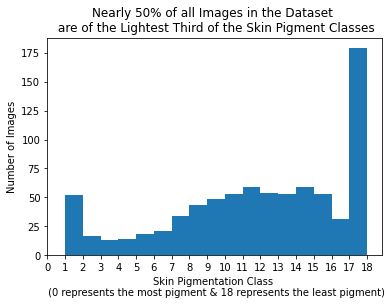

In [ ]:
plt.hist(df['skin_pigment_class'], bins=bin_list)
plt.ylabel('Number of Images')
plt.xlabel('Skin Pigmentation Class \n (0 represents the most pigment & 18 represents the least pigment)')
plt.xticks(np.arange(19))
plt.title('Nearly 50% of all Images in the Dataset \n are of the Least Pigmented Third of the Skin Pigmentation Classes')
plt.show

##Adjust Skin Tone for Cultivating a Dataset with More Diverse Skin Pigmentation

Since the majority of images scraped from the Google searches feature skin tones with relatively low levels of skin pigmentation, I used computer vision techniques for identifying skin in the images and applied a color filter and darkened the identified skin areas to create a more diverse datatset.

In [ ]:
#detect skin and adjust skin tone

#the following was adapted from code in "Skin Detection Using OpenCV Python" by Nalin Chhibber, published on January 23, 2018 from the link below:
#https://nalinc.github.io/blog/2018/skin-detection-python-opencv/


def change_skin_tone(image, blue, green, red, intensity, beta, gamma1, gamma2 ):
  image_copy = image.copy()   #copy original image
  #detect skin
  min_YCrCb = np.array([0,133,77],np.uint8)     #set min and max bgr arrays for detecting skin
  max_YCrCb = np.array([235,208,240],np.uint8)
  imageYCrCb = cv2.cvtColor(image_copy,cv2.COLOR_BGR2YCR_CB) #convert image_copy to YRC_CB color space 
  skinRegionYCrCb = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb) #find regions within min and max bgr arrays
  skinYCrCb = cv2.bitwise_and(image, image, mask = skinRegionYCrCb) #mask skin region to create new image "skinYCrCb"
  

  #add color filter to skinYCrCb
  #The following was adapted from code in the PyImageSearch article, "Transparent overlays with OpenCV" by Adrian Rosebrock PhD, published on March 7, 2016 from the link below:
  #https://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/

  image_h, image_w, image_c = image.shape  #get original image shape to match size to solid color overlay
  source = (blue, green, red)
  overlay = np.full((image_h, image_w, 3),source, dtype='uint8')  #create overlay
  skinLAB = cv2.cvtColor(skinYCrCb, cv2.COLOR_BGR2LAB)  #convert skin YCrCB to LAB color space
  skinLAB_wOverlay = cv2.addWeighted(overlay, intensity, skinLAB, beta, gamma1)  #apply overlay to skin
  skinBGR_wOverlay = cv2.cvtColor(skinLAB_wOverlay, cv2.COLOR_LAB2BGR)  #convert image with overlay to BGR color space

  #darken image
  lookUpTable = np.empty((1,256), np.uint8)
  for i in range(256):
    lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma2) * 255.0, 0, 255)
  res = cv2.LUT(skinBGR_wOverlay, lookUpTable)
  
  #detect background
  not_skinYCrCb = cv2.bitwise_and(image, image, mask = 255-skinRegionYCrCb)
  
  #add images together 
  new_image = cv2.add(not_skinYCrCb, res)
  new_image = cv2.GaussianBlur(new_image,(3,3),cv2.BORDER_DEFAULT) #addition of guassian blur to blur together the two combined images
  return new_image

In [ ]:
def master_function(image):
  dominant_color = get_dominant_color(image)
  original_skin_color_class = classify_color(dominant_color)
  new_image = change_skin_tone(image,
                blue=30,
                green=34,
                red = 45,
                intensity = 0.8,
                beta = 0.75,
                gamma1 = 10,
                gamma2 = 1.5)
  new_dominant_color = get_dominant_color(new_image)
  new_skin_color_class = classify_color(new_dominant_color)
  print('Original Skin Pigmentation Class: {}'.format(original_skin_color_class))
  cv2_imshow(new_image)
  print('Adjusted Sking Pigmentation Class: {}'.format(new_skin_color_class))

Original Image
Skin Condition: 0


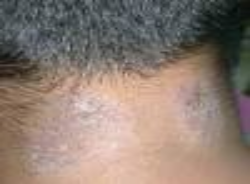


Adjusted Image
Original Skin Color Class: 15


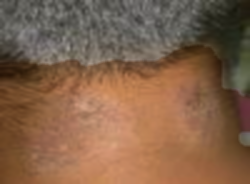

Skin Color Class for New Image: 7


In [ ]:
#display samples of original and adjusted images from dataset
print('Original Image')
print('Skin Condition: {}'.format(img_data[0][1]))
cv2_imshow(img_data[0][0])

print('\nAdjusted Image')
master_function(img_data[0][0])

Original Image
Skin Condition: 1


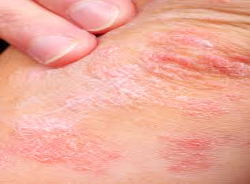


Adjusted Image
Original Skin Color Class: 14


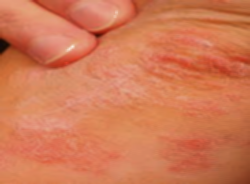

Skin Color Class for New Image: 7


In [ ]:
#View samples of original and adjusted images from dataset
print('Original Image')
print('Skin Condition: {}'.format(img_data[500][1]))
cv2_imshow(img_data[500][0])

print('\nAdjusted Image')
master_function(img_data[500][0])

Original Image
Skin Condition: 1


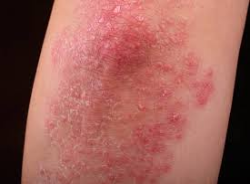


Adjusted Image
Original Skin Color Class: 10


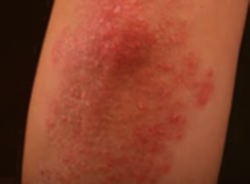

Skin Color Class for New Image: 4


In [ ]:
#Display samples of original and adjusted images from dataset
print('Original Image')
print('Skin Condition: {}'.format(img_data[650][1]))
cv2_imshow(img_data[650][0])

print('\nAdjusted Image')
master_function(img_data[650][0])

In [ ]:
#adjust skin color and determine skin pigmentation classes for entire dataset
color_changed_img_array = []
skin_condition_class = []
original_image_color_class = []
new_image_color_class=[]

for i in range(0, len(img_data)):
  dominant_color = get_dominant_color(img_data[i][0])
  original_skin_color_class = classify_color(dominant_color)
  new_image = change_skin_tone(img_data[i][0],
                blue=30,
                green=34,
                red = 45,
                intensity = 0.8,
                beta = 0.75,
                gamma1 = 10,
                gamma2 = 1.5)
  new_dominant_color = get_dominant_color(new_image)
  new_skin_color_class = classify_color(new_dominant_color)
  color_changed_img_array.append(new_image)
  skin_condition_class.append(img_data[i][1])
  original_image_color_class.append(original_skin_color_class)
  new_image_color_class.append(new_skin_color_class)

In [ ]:
#find average skin color classes from original and altered images
print('Average Skin Pigmentation Class from Original Image Dataset: {}'.format(round(mean(original_image_color_class),0)))
print('Mode Value for Skin Pigmentation Class from Original Image Dataset: {}'.format(mode(original_image_color_class)))
print('______________________________________________________')
print('Average Skin Pigmentation Class from Altered Image Dataset: {}'.format(mean(new_image_color_class),0))
print('Mode Value for Skin Pigmentation Class from Altered Image Dataset: {}'.format(mode(new_image_color_class)))


Average Skin Pigmentation Class from Original Image Dataset: 12.0
Mode Value for Skin Pigmentation Class from Original Image Dataset: 18
______________________________________________________
Average Skin Pigmentation Class from Altered Image Dataset: 6.382793017456359
Mode Value for Skin Pigmentation Class from Altered Image Dataset: 1


In [ ]:
#create and save dataframe with numpy arrays for a total of 1,604 images and their skin coniditions along with skin pigmentation classes:
data = {'image_array': color_changed_img_array,
        'skin_condition_class': skin_condition_class,
        'skin_pigmentation_class': new_image_color_class }

df1 = pd.DataFrame(data)

In [ ]:
df1.head()

image_array  ...  skin_pigmentation_class
0  [[[73, 78, 79], [73, 78, 79], [76, 81, 82], [7...  ...                        7
1  [[[245, 243, 249], [245, 244, 250], [247, 245,...  ...                        4
2  [[[136, 154, 161], [136, 154, 161], [135, 154,...  ...                        4
3  [[[235, 244, 244], [234, 243, 244], [233, 243,...  ...                        7
4  [[[56, 95, 149], [56, 94, 149], [55, 93, 147],...  ...                        5

[5 rows x 3 columns]

In [ ]:
df1['skin_pigmentation_class'].value_counts(ascending=False)

1     113
4      95
3      86
18     85
7      82
5      80
6      71
2      55
8      42
9      37
10     24
11     13
13      6
16      5
14      3
17      2
15      2
12      1
Name: skin_pigmentation_class, dtype: int64

<function matplotlib.pyplot.show>

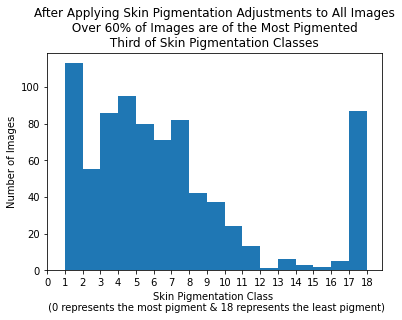

In [ ]:
plt.hist(df1['skin_pigmentation_class'], bins=bin_list)
plt.ylabel('Number of Images')
plt.xlabel('Skin Pigmentation Class \n (0 represents the most pigment & 18 represents the least pigment)')
plt.xticks(np.arange(19))
plt.title('After Applying Skin Pigmentation Adjustments to All Images\n Over 60% of Images are of the Most Pigmented \n Third of Skin Pigmentation Classes ')
plt.show

In [ ]:
#combine data frame for original images and adjusted images into one datafram
img_df = pd.concat([df, df1])

In [ ]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 801
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   image_array              1604 non-null   object
 1   skin_condition_class     1604 non-null   int64 
 2   skin_pigmentation_class  1604 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 50.1+ KB


In [ ]:
img_df.head()

image_array  ...  skin_pigmentation_class
0  [[[64, 61, 53], [65, 62, 54], [70, 67, 59], [7...  ...                        8
1  [[[243, 234, 231], [244, 235, 232], [247, 238,...  ...                       10
2  [[[135, 146, 144], [135, 146, 144], [134, 145,...  ...                       11
3  [[[236, 237, 228], [235, 237, 228], [234, 236,...  ...                       18
4  [[[115, 141, 178], [114, 141, 177], [113, 139,...  ...                       11

[5 rows x 3 columns]

In [ ]:
img_df['skin_pigmentation_class'].value_counts(ascending=False)

18    229
1     165
7     116
4     109
3      99
5      98
6      92
9      86
8      85
10     77
11     72
2      72
14     62
13     59
15     55
12     55
17     37
16     36
Name: skin_pigmentation_class, dtype: int64

<function matplotlib.pyplot.show>

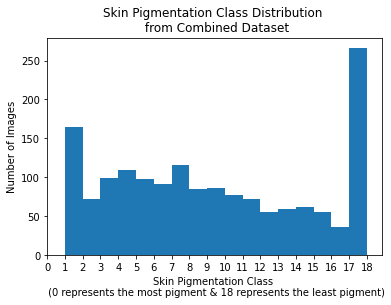

In [ ]:
plt.hist(img_df['skin_pigmentation_class'], bins=bin_list)
plt.ylabel('Number of Images')
plt.xlabel('Skin Pigmentation Class \n (0 represents the most pigment & 18 represents the least pigment)')
plt.xticks(np.arange(19))
plt.title('Skin Pigmentation Class Distribution \n from Combined Dataset')
plt.show

In [ ]:
#save data set by pickling
import pickle

pickle_out = open('img_df', 'wb')
pickle.dump(img_df,pickle_out)
pickle_out.close()

#Data Pipeline

In [ ]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 27kB/s 
     |████████████████████████████████| 450kB 41.0MB/s 
     |████████████████████████████████| 3.9MB 56.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=88a9d56f741f9be9aa7343861a15315de0374e0a207c8c4f964112425fccc90f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt


Using TensorFlow backend.


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#import dataset

%cd '/content/drive/My Drive/Final Capstone'

pickle_in = open('img_df', 'rb')
img_df = pickle.load(pickle_in)

/content/drive/My Drive/Final Capstone


In [ ]:
#assign x and y from saved dataset
X = list(img_df['image_array'])
y = list(img_df['skin_condition_class'])

In [ ]:
import numpy as np

X = np.array(X)
y = np.array(y)

In [ ]:
#scale the dataset from 0 to 255 (range of vlaues that can represent one pixel) 
X = X.astype('float32')
X /=255


In [ ]:
#split dataset into training and validation sets but store arrays for X train and test sets are are not scaled
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 7)

#CNN with 10 Layers

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape=(X.shape[1:])))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 182, 248, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 182, 248, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 91, 124, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 89, 122, 64)       36928     
_________________________________________________________________
activation_1 (Activation)    (None, 89, 122, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 61, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 171776)            0

In [ ]:
from datetime import datetime
import keras

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model.
model.fit(
    X_train,
    y_train, 
    batch_size=64,
    epochs=5, 
    callbacks=[tensorboard_callback])

Train on 1283 samples
Epoch 1/5
1283/1283 [==============================] - 3s 2ms/sample - loss: 2.1924 - accuracy: 0.5401
Epoch 2/5
1283/1283 [==============================] - 1s 1ms/sample - loss: 0.6349 - accuracy: 0.6500
Epoch 3/5
1283/1283 [==============================] - 1s 1ms/sample - loss: 0.5331 - accuracy: 0.7420
Epoch 4/5
1283/1283 [==============================] - 1s 1ms/sample - loss: 0.4396 - accuracy: 0.7950
Epoch 5/5
1283/1283 [==============================] - 1s 1ms/sample - loss: 0.3514 - accuracy: 0.8472


In [ ]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

In [ ]:
predictions = model.predict(X_test)

In [ ]:
#view first 10 predictions for reference
predictions[0:10]

array([[0.92855966],
       [0.5135495 ],
       [0.993299  ],
       [0.5117113 ],
       [0.71416813],
       [0.6251599 ],
       [0.74028975],
       [0.24736726],
       [0.40498474],
       [0.911295  ]], dtype=float32)

In [ ]:
rounded_predictions = model.predict_classes(X_test)

In [ ]:
#view first 10 predicted classes for reference:
rounded_predictions[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1]], dtype=int32)

In [ ]:
#create confusion matrix

from sklearn.metrics import confusion_matrix
import itertools

cnn_confusion_matrix = confusion_matrix(y_test, rounded_predictions)

In [ ]:
cnn_confusion_matrix

array([[125,  44],
       [ 26, 126]])

In [ ]:
res_eczema = 0
for i in range(len(y_test)):
  if 0 == y_test[i]:
    res_eczema +=1

res_psoriasis = 0
for i in range(len(y_test)):
  if 1 == y_test[i]:
    res_psoriasis +=1

print('Total Number of True Images of Eczema in Test Dateset: {}'.format(res_eczema))
print('Total Number of True Images of Psoriasis in Test Dateset: {}'.format(res_psoriasis))

Total Number of True Images of Eczema in Test Dateset: 169
Total Number of True Images of Psoriasis in Test Dateset: 152


In [ ]:
#plot confusion matrix

from sklearn.metrics import plot_confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Diagnosis')
    plt.xlabel('Predicted Diagnosis\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

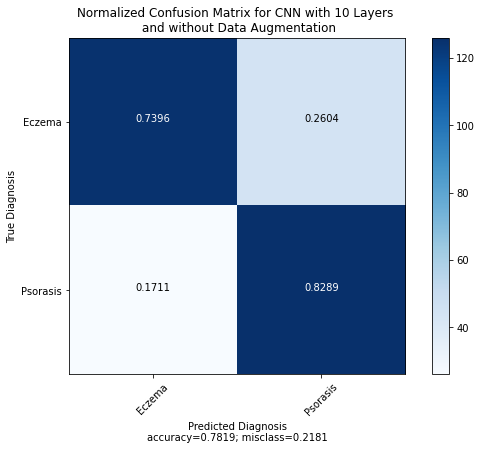

In [ ]:
plot_confusion_matrix(cnn_confusion_matrix, 
                      target_names=['Eczema', 'Psorasis'],
                      title = "Normalized Confusion Matrix for CNN with 10 Layers \n and without Data Augmentation")

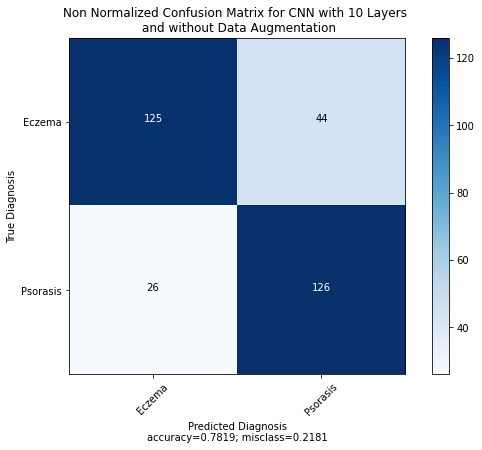

In [ ]:
plot_confusion_matrix(cnn_confusion_matrix, 
                      target_names=['Eczema', 'Psorasis'],
                      title = "Non Normalized Confusion Matrix for CNN with 10 Layers \n and without Data Augmentation",
                      normalize=False)

In [ ]:
#calculate precsision and recall
from sklearn.metrics import classification_report
report = classification_report(y_test, rounded_predictions, target_names=['Eczema', 'Psoriasis'])

In [ ]:
print(report)

              precision    recall  f1-score   support

      Eczema       0.83      0.74      0.78       169
   Psoriasis       0.74      0.83      0.78       152

    accuracy                           0.78       321
   macro avg       0.78      0.78      0.78       321
weighted avg       0.79      0.78      0.78       321



In [ ]:
model.evaluate(X_test, y_test)

321/321 [==============================] - 0s 802us/sample - loss: 0.5630 - accuracy: 0.7539


[0.5630240663189754, 0.7538941]

83% of predicted Eczema cases from the test set were correct; whereas only 74% of the images that were labeled as Psoriasis by the model were actually images of Psoriasis.

Likewise, 74% of Eczema cases were correctly identified, but 83% of Psoriasis cases were corrected predicted by the model.

#CNN with 10 Layers and Data Augmentation

I attempted to improve the performance of the model above by adding data augmentation due the rather small size of my data set.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims 

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

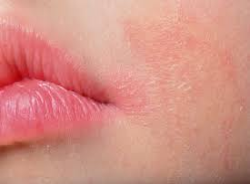

In [ ]:
#test data augmentation on image from dataset

sample_img = img_data[45][0]
cv2_imshow(sample_img)

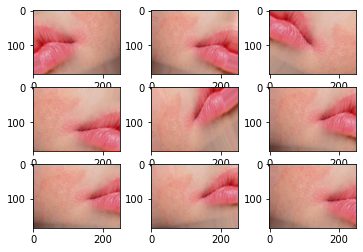

In [ ]:
#the following code was adapted from the Machine Learning Mastery article, "How to Configure Image Data Augmentation in Keras" by Jason Brownlee PhD, last updated on July 5, 2019 in the link below:
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

sample_img_bgr=cv.cvtColor(sample_img, cv2.COLOR_RGB2BGR)
# load the image
sample_img_bgr = expand_dims(sample_img_bgr, 0)

# prepare iterator
it = datagen.flow(sample_img_bgr, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_datagen = datagen.flow(X_train, y_train)

In [ ]:
model.fit_generator(train_datagen, steps_per_epoch=len(X_train)//batch_size, epochs=5, validation_data=(X_test, y_test))


  ...
    to  
  ['...']
Train for 40 steps, validate on 321 samples
Epoch 1/5
40/40 [==============================] - 13s 328ms/step - loss: 0.6816 - accuracy: 0.5380 - val_loss: 21.9714 - val_accuracy: 0.5109
Epoch 2/5
40/40 [==============================] - 13s 326ms/step - loss: 0.6840 - accuracy: 0.5196 - val_loss: 16.2502 - val_accuracy: 0.5639
Epoch 3/5
40/40 [==============================] - 13s 327ms/step - loss: 0.6830 - accuracy: 0.5260 - val_loss: 10.1962 - val_accuracy: 0.5826
Epoch 4/5
40/40 [==============================] - 13s 325ms/step - loss: 0.6820 - accuracy: 0.5244 - val_loss: 13.6482 - val_accuracy: 0.5701
Epoch 5/5
40/40 [==============================] - 13s 330ms/step - loss: 0.6765 - accuracy: 0.5292 - val_loss: 17.0341 - val_accuracy: 0.5639


Adding data augmentation actually seemed to damgage the performance of the model.  Even when increasing the number of epochs, the accuracy on both the test and validation data was significantly lower than the accuracy from the model without augmenting the data.  

In [ ]:
rounded_predictions_da = model.predict_classes(X_test)

In [ ]:
cnn_confusion_matrix_da = confusion_matrix(y_test, rounded_predictions_da)

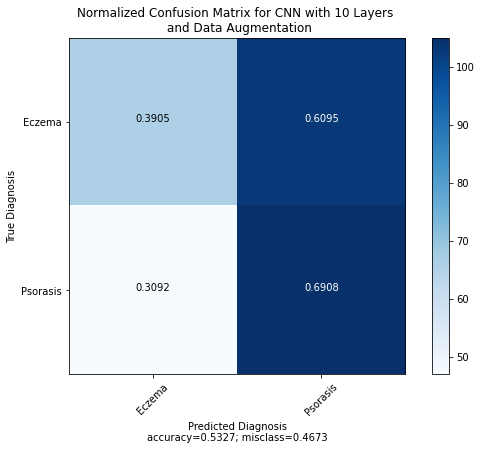

In [ ]:
plot_confusion_matrix(cnn_confusion_matrix_da, 
                      target_names=['Eczema', 'Psorasis'],
                      title = "Normalized Confusion Matrix for CNN with 10 Layers \n and Data Augmentation")

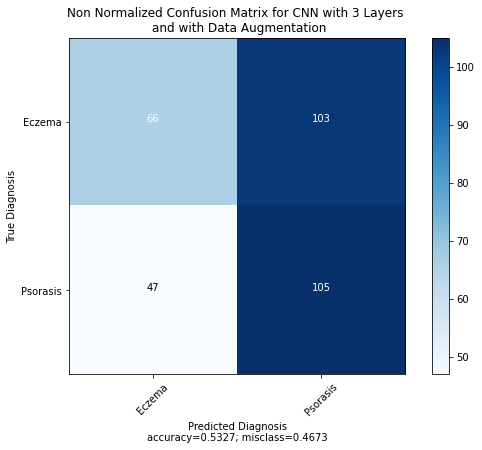

In [ ]:
plot_confusion_matrix(cnn_confusion_matrix_da, 
                      target_names=['Eczema', 'Psorasis'],
                      title = "Non Normalized Confusion Matrix for CNN with 3 Layers \n and with Data Augmentation",
                      normalize=False)

In [ ]:
report = classification_report(y_test, rounded_predictions_da, target_names=['Eczema', 'Psoriasis'])
print(report)

              precision    recall  f1-score   support

      Eczema       0.58      0.39      0.47       169
   Psoriasis       0.50      0.69      0.58       152

    accuracy                           0.53       321
   macro avg       0.54      0.54      0.53       321
weighted avg       0.55      0.53      0.52       321



Only a little over half of the predictions for both Eczema and Psoriasis actually matched the true diagnosis.  
Since Eczema and Psoriasis are visually similar, it is possible that the manipulations performed in the data augmentation maybe altering the fine details that distinguish the two skin diagnosis, leading to more misclassifications.

#CNN with 20 layers without Data Augmentation

In [ ]:
#create the model

#The following code has been adapted from the book, "Building Machine Learning and Deep Learning Models on Google Cloud Platform" by Ekaba Bisong
def model_fn():
  model_input = tf.keras.layers.Input(shape=(184, 250, 3))
  x = tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu')(model_input)
  x = tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(x)
  x = tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu')(x)
  x = tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(x)
  x = tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu')(x)
  x = tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu')(x)
  x = tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  output = tf.keras.layers.Dense(10, activation='softmax')(x)

  model = tf.keras.Model(inputs=model_input, outputs=output)
  model.compile(optimizer=tf.keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = model_fn()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 184, 250, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 184, 250, 64)      4864      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 184, 250, 64)      102464    
_________________________________________________________________
batch_normalization (BatchNo (None, 184, 250, 64)      256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 184, 250, 64)      102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 92, 125, 64)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 92, 125, 64)       102464

In [ ]:
#create dataset pipeline
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).repeat().batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [ ]:
model.fit(train_ds, epochs=10, steps_per_epoch=12)

Train for 12 steps
Epoch 1/10
12/12 [==============================] - 6s 499ms/step - loss: 1.3431 - accuracy: 0.5172
Epoch 2/10
12/12 [==============================] - 2s 199ms/step - loss: 1.2729 - accuracy: 0.4688
Epoch 3/10
12/12 [==============================] - 2s 201ms/step - loss: 1.2841 - accuracy: 0.4635
Epoch 4/10
12/12 [==============================] - 2s 200ms/step - loss: 1.2269 - accuracy: 0.4896
Epoch 5/10
12/12 [==============================] - 2s 199ms/step - loss: 1.1181 - accuracy: 0.5391
Epoch 6/10
12/12 [==============================] - 2s 199ms/step - loss: 1.2841 - accuracy: 0.4635
Epoch 7/10
12/12 [==============================] - 2s 200ms/step - loss: 1.3585 - accuracy: 0.4297
Epoch 8/10
12/12 [==============================] - 2s 200ms/step - loss: 1.2898 - accuracy: 0.4609
Epoch 9/10
12/12 [==============================] - 2s 200ms/step - loss: 1.1811 - accuracy: 0.5104
Epoch 10/10
12/12 [==============================] - 2s 199ms/step - loss: 1.2383

In [ ]:
predictions = model.predict(X_test)

In [ ]:
rounded_predictions=predictions.astype('int64')

In [ ]:
rounded_predictions.min()

0

In [ ]:
predictions.max()

0.101876765

In [ ]:
predictions.min()

0.09805888

The model with 20 layers predicted that all 321 images in the test data set were of Eczema.  This was the poorest performing model at thus far.  It is possible that simpiler CNN architecture may perform better with the data due to the relativley small size of the dataset.

#ResNet with 50 layers without Data Augmentation

In [ ]:
import pandas as pd
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

In [ ]:
IMG_WIDTH =250
IMG_HEIGHT = 184

In [ ]:
#upload ResNet-50 in keras  
from keras import applications
base_model = applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [ ]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.5)(x)
predictions = Dense(1, activation='softmax')(x)   
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 184, 250, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 190, 256, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 92, 125, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 92, 125, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
1283/1283 [==============================] - 74s 58ms/step - loss: 7.3977 - accuracy: 0.5175
Epoch 2/5
1283/1283 [==============================] - 50s 39ms/step - loss: 7.3977 - accuracy: 0.5175
Epoch 3/5
1283/1283 [==============================] - 50s 39ms/step - loss: 7.3977 - accuracy: 0.5175
Epoch 4/5
1283/1283 [==============================] - 50s 39ms/step - loss: 7.3977 - accuracy: 0.5175
Epoch 5/5
1283/1283 [==============================] - 50s 39ms/step - loss: 7.3977 - accuracy: 0.5175


Surprisingly, the ResNet Model performance was worse than that of the CNN's

#Auto Keras 

In [ ]:
!pip install autokeras

     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=ed79f4e2e078094005235ba848d9e28d3418ac716e79fec6ae80f51385825a42
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=ad51957d72951f61426efebd3212481f7e07c9a0fd7dd41dbbf07eae86e453af
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import autokeras as ak

In [ ]:
X_train.shape

(1283, 184, 250, 3)

In [ ]:
y_train.shape

(1283,)

In [ ]:
clf = ak.ImageClassifier(max_trials=25)
clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15)

Train for 41 steps, validate for 11 steps
Epoch 1/15
41/41 [==============================] - 4s 89ms/step - loss: 1.2731 - accuracy: 0.5713 - val_loss: 0.6781 - val_accuracy: 0.6012
Epoch 2/15
41/41 [==============================] - 3s 76ms/step - loss: 0.6113 - accuracy: 0.6586 - val_loss: 0.5725 - val_accuracy: 0.6885
Epoch 3/15
41/41 [==============================] - 3s 77ms/step - loss: 0.4044 - accuracy: 0.8348 - val_loss: 0.4832 - val_accuracy: 0.7165
Epoch 4/15
41/41 [==============================] - 3s 74ms/step - loss: 0.2459 - accuracy: 0.9065 - val_loss: 0.4845 - val_accuracy: 0.7414
Epoch 5/15
41/41 [==============================] - 3s 77ms/step - loss: 0.1582 - accuracy: 0.9454 - val_loss: 0.4539 - val_accuracy: 0.8037
Epoch 6/15
41/41 [==============================] - 3s 77ms/step - loss: 0.1241 - accuracy: 0.9634 - val_loss: 0.4501 - val_accuracy: 0.8069
Epoch 7/15
41/41 [==============================] - 3s 75ms/step - loss: 0.0983 - accuracy: 0.9758 - val_loss: 0

Train for 41 steps, validate for 11 steps
Epoch 1/15
41/41 [==============================] - 14s 333ms/step - loss: 0.7983 - accuracy: 0.5277 - val_loss: 131.0992 - val_accuracy: 0.5514
Epoch 2/15
41/41 [==============================] - 9s 211ms/step - loss: 0.7031 - accuracy: 0.5511 - val_loss: 0.6730 - val_accuracy: 0.5545
Epoch 3/15
41/41 [==============================] - 7s 182ms/step - loss: 0.6842 - accuracy: 0.5581 - val_loss: 0.6809 - val_accuracy: 0.5732
Epoch 4/15
41/41 [==============================] - 7s 179ms/step - loss: 0.6760 - accuracy: 0.5690 - val_loss: 0.6857 - val_accuracy: 0.5421
Epoch 5/15
41/41 [==============================] - 7s 178ms/step - loss: 0.6754 - accuracy: 0.5939 - val_loss: 14.5586 - val_accuracy: 0.4984
Epoch 6/15
41/41 [==============================] - 7s 178ms/step - loss: 0.7236 - accuracy: 0.5526 - val_loss: 0.7680 - val_accuracy: 0.5483
Epoch 7/15
41/41 [==============================] - 7s 177ms/step - loss: 0.6866 - accuracy: 0.5713 - 

Train for 41 steps, validate for 11 steps
Epoch 1/15
41/41 [==============================] - 4s 89ms/step - loss: 1.6571 - accuracy: 0.5612 - val_loss: 0.6798 - val_accuracy: 0.6075
Epoch 2/15
41/41 [==============================] - 3s 77ms/step - loss: 0.6590 - accuracy: 0.6118 - val_loss: 0.6642 - val_accuracy: 0.6262
Epoch 3/15
41/41 [==============================] - 3s 75ms/step - loss: 0.5504 - accuracy: 0.7233 - val_loss: 0.5808 - val_accuracy: 0.6854
Epoch 4/15
41/41 [==============================] - 3s 77ms/step - loss: 0.3765 - accuracy: 0.8387 - val_loss: 0.4863 - val_accuracy: 0.7695
Epoch 5/15
41/41 [==============================] - 3s 75ms/step - loss: 0.2308 - accuracy: 0.9158 - val_loss: 0.5010 - val_accuracy: 0.8037
Epoch 6/15
41/41 [==============================] - 3s 74ms/step - loss: 0.1569 - accuracy: 0.9493 - val_loss: 0.5661 - val_accuracy: 0.7819
Epoch 7/15
41/41 [==============================] - 3s 77ms/step - loss: 0.1175 - accuracy: 0.9618 - val_loss: 0

INFO:tensorflow:Oracle triggered exit
Train for 41 steps, validate for 11 steps
Epoch 1/15
41/41 [==============================] - 4s 86ms/step - loss: 1.1493 - accuracy: 0.5261 - val_loss: 0.6794 - val_accuracy: 0.5732
Epoch 2/15
41/41 [==============================] - 3s 74ms/step - loss: 0.6142 - accuracy: 0.6578 - val_loss: 0.6326 - val_accuracy: 0.6511
Epoch 3/15
41/41 [==============================] - 3s 74ms/step - loss: 0.4372 - accuracy: 0.8083 - val_loss: 0.5588 - val_accuracy: 0.7040
Epoch 4/15
41/41 [==============================] - 3s 75ms/step - loss: 0.2504 - accuracy: 0.9104 - val_loss: 0.4991 - val_accuracy: 0.7227
Epoch 5/15
41/41 [==============================] - 3s 74ms/step - loss: 0.1591 - accuracy: 0.9470 - val_loss: 0.5004 - val_accuracy: 0.7414
Epoch 6/15
41/41 [==============================] - 3s 74ms/step - loss: 0.1287 - accuracy: 0.9657 - val_loss: 0.4506 - val_accuracy: 0.8037
Epoch 7/15
41/41 [==============================] - 3s 74ms/step - loss: 0

In [ ]:
model.save('my_model')  # creates a HDF5 file 'my_model.h5'

In [ ]:
from tensorflow.keras.models import load_model

#load autokeras model in keras
model = load_model('my_model')

In [ ]:
model.evaluate(X_train, y_train)

1283/1283 [==============================] - 1s 880us/sample - loss: 0.0131 - accuracy: 0.9961


[0.013133329912214936, 0.99610287]

In [ ]:
model.evaluate(X_test, y_test)

321/321 [==============================] - 0s 817us/sample - loss: 0.4820 - accuracy: 0.8785


[0.4820448165742036, 0.8785047]

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 184, 250, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 184, 250, 3)       7         
_________________________________________________________________
conv2d (Conv2D)              (None, 182, 248, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 246, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 123, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 123, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 708480)            0     

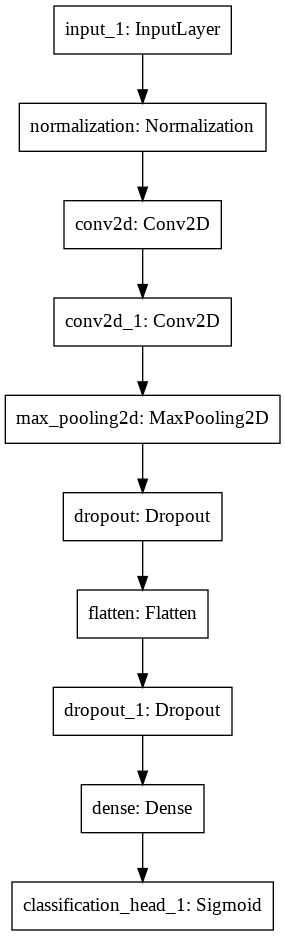

In [ ]:
from keras.utils.vis_utils import plot_model

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
len(predictions)

321

In [ ]:
#convert probabilities to classes
rounded_predictions = (predictions > 0.5).astype(np.int)

In [ ]:
rounded_predictions[0:10]

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1]])

In [ ]:
y_test[0:10]

array([1, 1, 0, 0, 1, 0, 1, 0, 0, 1])

In [ ]:
from sklearn.metrics import confusion_matrix

automl_cm = confusion_matrix(y_test, rounded_predictions)

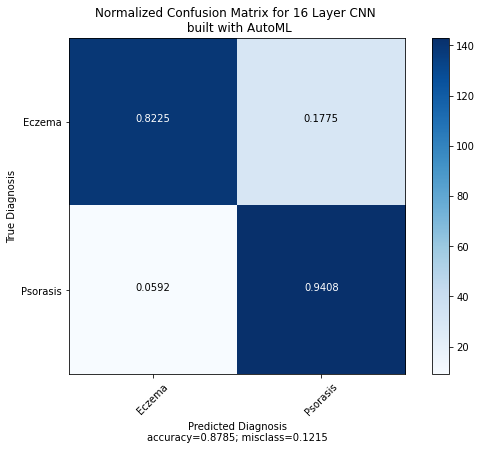

In [ ]:
plot_confusion_matrix(automl_cm, 
                      target_names=['Eczema', 'Psorasis'],
                      title = "Normalized Confusion Matrix for CNN \n built with AutoML")

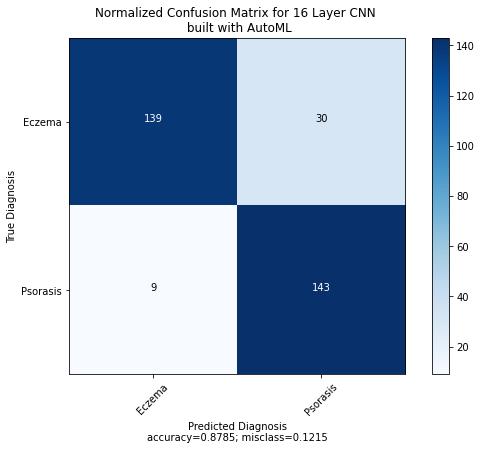

In [ ]:
plot_confusion_matrix(automl_cm, 
                      target_names=['Eczema', 'Psorasis'],
                      title = "Non-Normalized Confusion Matrix for CNN \n built with AutoML",
                      normalize = False)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, rounded_predictions, target_names=['Eczema', 'Psoriasis'])
print(report)

              precision    recall  f1-score   support

      Eczema       0.94      0.82      0.88       169
   Psoriasis       0.83      0.94      0.88       152

    accuracy                           0.88       321
   macro avg       0.88      0.88      0.88       321
weighted avg       0.89      0.88      0.88       321



##Testing Model Performance

Since the above model performs with an accuracy of over 85% on the validation data, I proceeded with testing the model performance on a new set of 32 images of Eczema and 32 images of Psoriasis not previously seen by the model.  These images were collected from the photos made available to the larger AI in Dermatology project.

In [ ]:
#read in final test dataset from drive and store in list
CATEGORIES = ['Eczema', 'Psoriasis']
DATADIR = '/content/drive/My Drive/Final Capstone/Final_Test_Dataset'

IMG_HT = 184
IMG_WD = 250

final_image_data = []

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  class_num = CATEGORIES.index(category)
  for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path, img))
      new_array = cv2.resize(img_array,(IMG_WD, IMG_HT))
      final_image_data.append([new_array, class_num])

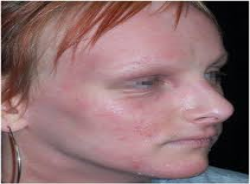

In [ ]:
#view samples from final test dataset
cv2_imshow(final_image_data[15][0])

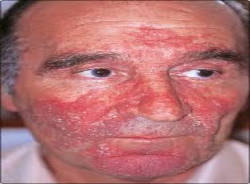

In [ ]:
cv2_imshow(final_image_data[30][0])

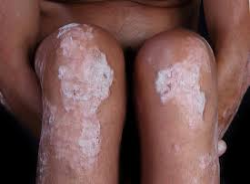

In [ ]:
cv2_imshow(final_image_data[60][0])

In [ ]:
#assess skin pigmentation classes in final test set
final_test_set_skin_pigmentation_classes = []
for i in range (0, len(final_image_data)):
  final_test_set_skin_pigmentation_classes.append(classify_color(get_dominant_color(final_image_data[i][0])))

In [ ]:
final_test_set_skin_pigmentation_classes[:10]

[18, 12, 16, 6, 8, 3, 12, 14, 11, 9]

In [ ]:
data = {'skin_pigmentation_class': final_test_set_skin_pigmentation_classes }

final_test_df = pd.DataFrame(data)

In [ ]:
final_test_df['skin_pigmentation_class'].value_counts()

18    8
14    7
10    6
12    5
11    5
8     5
7     5
15    4
9     4
16    3
13    3
1     3
17    2
6     2
4     1
3     1
Name: skin_pigmentation_class, dtype: int64

In [ ]:
final_test_df['skin_pigmentation_class'].describe()

count    64.000000
mean     11.421875
std       4.510322
min       1.000000
25%       8.000000
50%      11.500000
75%      15.000000
max      18.000000
Name: skin_pigmentation_class, dtype: float64

In [ ]:
img_df['previous_color_class'].mean()

11.542394014962593

The average skin color class from the original training and validation datasets and the final test set are approximately the same.

<function matplotlib.pyplot.show>

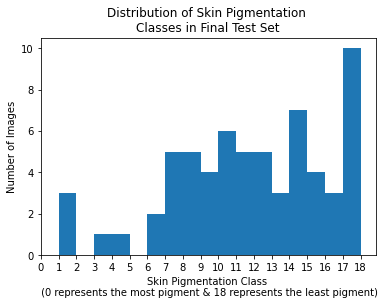

In [ ]:
bin_list = list(range(1,19))

plt.hist(final_test_df['skin_pigmentation_class'], bins=bin_list)
plt.ylabel('Number of Images')
plt.xlabel('Skin Pigmentation Class \n (0 represents the most pigment & 18 represents the least pigment)')
plt.xticks(np.arange(19))
plt.title('Distribution of Skin Pigmentation \nClasses in Final Test Set')
plt.show

In [ ]:
X_final_test=[]
y_final_test=[]

for features, label in final_image_data:
  X_final_test.append(features)
  y_final_test.append(label)

In [ ]:
#convert to numpy array
import numpy as np

X_final_test = np.array(X_final_test)
y_final_test = np.array(y_final_test)

In [ ]:
#scale array
X_final_test= X_final_test.astype('float32')
X_final_test /= 255

In [ ]:
model.evaluate(X_final_test, y_final_test)

64/64 [==============================] - 0s 2ms/sample - loss: 1.3231 - accuracy: 0.6406


[1.3231109082698822, 0.640625]

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
predictions = model.predict(X_final_test)

In [ ]:
#convert probabilities to classes
rounded_predictions = (predictions > 0.5).astype(np.int)

In [ ]:
final_test_confusion_matrix = confusion_matrix(y_final_test, rounded_predictions)

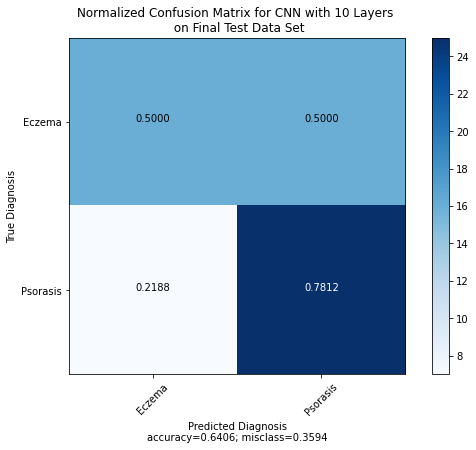

In [ ]:
plot_confusion_matrix(final_test_confusion_matrix, 
                      target_names=['Eczema', 'Psorasis'],
                      title = "Normalized Confusion Matrix for CNN with 10 Layers \n on Final Test Data Set")

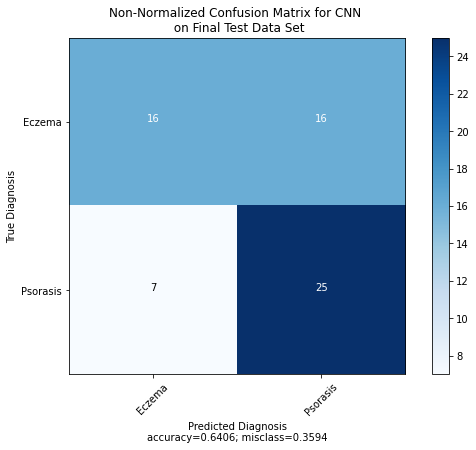

In [ ]:
plot_confusion_matrix(final_test_confusion_matrix, 
                      target_names=['Eczema', 'Psorasis'],
                      title = "Non-Normalized Confusion Matrix for CNN \n on Final Test Data Set",
                      normalize = False)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_final_test, rounded_predictions, target_names=['Eczema', 'Psoriasis'])
print(report)

              precision    recall  f1-score   support

      Eczema       0.70      0.50      0.58        32
   Psoriasis       0.61      0.78      0.68        32

    accuracy                           0.64        64
   macro avg       0.65      0.64      0.63        64
weighted avg       0.65      0.64      0.63        64



#Auto Keras Model with Data Augmentation
Although the model from the previous model had an accuracy of over 85% on the training and validation data; the model performed poorly on the final test data set of images not previously seen by the model.  Being that the model is overfit to the training data, I attempted to improve the model's performance on the final test dataset by using data augmentation; although this method was seemingly detrimental to the model performance on the validation data set in the previous CNN. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_datagen = datagen.flow(X_train, y_train)

In [ ]:
#model = policy_network()
#model.fit(images, actions,
          batch_size=256,
          epochs=10,
          shuffle=True)
#action = model.predict(image)

In [ ]:
batch_size = 32
model.fit_generator(train_datagen, steps_per_epoch=len(X_train)//batch_size, epochs=15, validation_data=(X_test, y_test))

  ...
    to  
  ['...']
Train for 40 steps, validate on 321 samples
Epoch 1/15
40/40 [==============================] - 12s 291ms/step - loss: 0.6460 - accuracy: 0.5971 - val_loss: 0.6502 - val_accuracy: 0.6199
Epoch 2/15
40/40 [==============================] - 12s 300ms/step - loss: 0.6591 - accuracy: 0.5867 - val_loss: 0.6472 - val_accuracy: 0.6293
Epoch 3/15
40/40 [==============================] - 12s 298ms/step - loss: 0.6477 - accuracy: 0.5947 - val_loss: 0.6407 - val_accuracy: 0.6355
Epoch 4/15
40/40 [==============================] - 12s 295ms/step - loss: 0.6407 - accuracy: 0.6211 - val_loss: 0.6325 - val_accuracy: 0.6355
Epoch 5/15
40/40 [==============================] - 12s 293ms/step - loss: 0.6374 - accuracy: 0.6051 - val_loss: 0.6307 - val_accuracy: 0.6075
Epoch 6/15
40/40 [==============================] - 12s 295ms/step - loss: 0.6467 - accuracy: 0.6027 - val_loss: 0.6463 - val_accuracy: 0.6355
Epoch 7/15
40/40 [==============================] - 12s 294ms/step - loss

In [ ]:
model.evaluate(X_final_test, y_final_test)

64/64 [==============================] - 0s 886us/sample - loss: 0.9265 - accuracy: 0.5312


[0.9265468567609787, 0.53125]

Again, data augmentation has had a negative effect on model accuracy.

#Transfer Learning with Data Augmentation with ResNet50

In [ ]:
#the following was adapted from code in the Machine Learning Mastery article, "Transfer Learning in Keras with Computer Vision Models" by Jason Brownlee PHD, published on May 15, 2019 from the link below:
#https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

from keras.applications.resnet50 import ResNet50, preprocess_input

IMG_HT = 184
IMG_WD = 250

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(IMG_HT, IMG_WD, 3))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims 

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_datagen = datagen.flow(X_train, y_train)

In [ ]:

from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = ["Eczema","Psoriasis"]
FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list)-1)

In [ ]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from datetime import datetime

NUM_EPOCHS = 15
BATCH_SIZE = 32
num_train_images = len(X_train)

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

finetune_model.fit_generator(train_datagen, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True)


Epoch 1/15
40/40 [==============================] - 15s 372ms/step - loss: 7.4414 - accuracy: 0.5188
Epoch 2/15
40/40 [==============================] - 12s 288ms/step - loss: 7.4295 - accuracy: 0.5196
Epoch 3/15
40/40 [==============================] - 12s 290ms/step - loss: 7.4630 - accuracy: 0.5133
Epoch 4/15
40/40 [==============================] - 12s 296ms/step - loss: 7.5568 - accuracy: 0.5229
Epoch 5/15
40/40 [==============================] - 11s 282ms/step - loss: 7.7051 - accuracy: 0.5012
Epoch 6/15
40/40 [==============================] - 11s 285ms/step - loss: 7.4106 - accuracy: 0.5284
Epoch 7/15
40/40 [==============================] - 11s 287ms/step - loss: 7.2634 - accuracy: 0.5156
Epoch 8/15
40/40 [==============================] - 11s 280ms/step - loss: 7.4270 - accuracy: 0.5156
Epoch 9/15
40/40 [==============================] - 11s 263ms/step - loss: 7.4438 - accuracy: 0.5229
Epoch 10/15
40/40 [==============================] - 11s 276ms/step - loss: 7.4055 - accura

In [ ]:
#evaluate performance on test data set
finetune_model.evaluate(X_final_test, y_final_test)

64/64 [==============================] - 1s 22ms/step


[7.624619007110596, 0.5]

#Conclusion
After building several different models, including models with transfer learning, data augmentation, residual neural networks, and neural architecture search, the best model was a CNN built via AutoKeras.  This model was over 87% accurate in classifying images of Eczema and Psoriasis in the validation test set.  However this model did exhibit over-fitting, as it was over 99% accurate in predicting the classes of the training dataset.    

The issue of over-fitting was emphasized in the performance on the final test dataset for which the model was only 64% accurate in differentiating Eczema from Psoriasis.  I believe the poor performance on the final test data set is a result of the small size of the training and validation data sets as well as the natural visual similarities between Eczema and Psoriasis, especially in their early stages.

While this capstone did not deliver a high performance on the final test set; this project has re-emphasized the need for a larger image dataset and has supported the relevance for the larger Ai in Dermatology project in which a Generative Adversarial Neural Network will be used to expand the image dataset to improve CNN performance.

#References

<sup>1</sup> “Eczema Prevalence, Quality of Life and Economic Impact.” National Eczema Association, National Eczema Association, nationaleczema.org/research/eczema-facts/. Web 19 May 2020

<sup>2</sup> “Statistics.” Statistics | National Psoriasis Foundation, National Psoriasis Foundation, www.psoriasis.org/content/statistics. Web 19 May 2020

<sup>3</sup> “About Us.” NAD, Nigerian Association of Dermatologists, nad.org.ng/history.php. Web. 19 May 2020.


